<a href="https://www.kaggle.com/code/luchozm22/signlanguagecnn?scriptVersionId=272699793" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mixed_precision.set_global_policy('mixed_float16')

2025-11-01 19:39:46.342959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762025986.528608      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762025986.590371      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
import numpy as np
import matplotlib.pyplot as plt
import math

# GLOBAL VARIABLES

In [3]:
# GLOBAL VARIABLES
IMG_SIZE = (200, 200)
BATCH_SIZE = 96
TRAIN_LOCATION = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
TRAIN_LOCATION_SMALL = '/kaggle/input/asl-dataset-corrected/asl-test_corrected'
VALIDATION_LOCATION = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
EPOCHS = 25
N_CLASSES = 29

# PREPROCESING

In [4]:
def preprocess(img, label):

    img = tf.cast(img, tf.float32) 
    img_preprocessed = preprocess_input(img) 
    label = tf.one_hot(label, depth=N_CLASSES)

    return img_preprocessed, label

# DATA AUGMENTATION

In [5]:
from keras.layers import RandomRotation, RandomZoom
from keras_cv.layers import RandomCutout

In [6]:
random_rotation = RandomRotation(factor=(-0.18, 0.18), dtype=tf.float32)
random_cutout = RandomCutout(height_factor=0.05, width_factor=0.05, dtype=tf.float32)
random_zoom = RandomZoom(height_factor=0.1, width_factor=0.1, dtype=tf.float32)

I0000 00:00:1762026005.344348      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
def augment_pre_batch(img, label):
    # Apply augmentations randomly
    if tf.random.uniform([]) < 0.5:
        img = random_rotation(img)

    if tf.random.uniform([]) < 0.5:
        img = random_cutout(img)

    if tf.random.uniform([]) < 0.5:
        img = random_zoom(img)

    return img, label


In [8]:
def build_data_set(folder_loc, split=None, image_size=IMG_SIZE, batch_size=BATCH_SIZE, isTrain=False, data_augmentation=False):
    
    loader_args = {
        'directory': folder_loc,
        'image_size': image_size,
        'seed': SEED,
        'label_mode': 'int',
        'batch_size': None 
    }

    if split:
        loader_args['validation_split'] = split
        loader_args['subset'] = "training" if isTrain else "validation"
    
    ds = keras.preprocessing.image_dataset_from_directory(**loader_args)
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)

    if isTrain:
        #ds = ds.cache()
        ds = ds.shuffle(buffer_size=256)
    
    if isTrain and data_augmentation:
       ds = ds.map(augment_pre_batch, num_parallel_calls=AUTOTUNE)


    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    

    return ds

In [9]:
train_ds = build_data_set(TRAIN_LOCATION, split=0.2, isTrain=True, data_augmentation=True)
test_ds = build_data_set(TRAIN_LOCATION, split=0.2, isTrain=False) 

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


# MODEL

## 1. Own CNN Model

In [10]:
from keras import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [11]:
def get_cnn_model(N_CLASSES):
    return Sequential([
        Input(shape=(200, 200, 3)),

        # Block 1
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(),

        # Block 2
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(),

        # Block 3
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(N_CLASSES, activation="softmax", dtype='float32')
    ])

## 2. MobileNetV3 Large

In [12]:
from keras.applications import MobileNetV3Large

In [13]:
def create_transfer_model(n_classes, input_shape=(200, 200, 3)):
    
    inputs = Input(shape=input_shape, name="input_layer")
    
    base_model = MobileNetV3Large(
        input_tensor=inputs,
        weights='imagenet',  
        include_top=False,   
        pooling=None        
    )   
    base_model.trainable = False
    x = base_model.output

    x = GlobalAveragePooling2D(name="global_avg_pool")(x)
    
    # Now add the classifier head you defined
    x = Dense(256, activation="relu", name="dense_head_1")(x)
    x = Dropout(0.5, name="dropout_head")(x)
    
    # The output layer for n_classes
    outputs = Dense(n_classes, activation="softmax", name="output_layer", dtype="float32")(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    
    return model

# Trainning

## 1. Callbacks

In [14]:
def get_callbacks(model_name, metric):
   
    val_metric = 'val_' + metric
    # Model Checkpoint
    ckpt_cb = keras.callbacks.ModelCheckpoint((model_name + '_best.weights.h5'),
                                             monitor= val_metric,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max')
    # Early Stopping
    es_cb = keras.callbacks.EarlyStopping(
        monitor=val_metric,  
        mode='max',          
        patience=10,        
        restore_best_weights=True 
    )

    return [ckpt_cb, es_cb]

## Compile

In [15]:
def compile_model(model, optimizer, loss, metrics):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

In [16]:
from keras.metrics import Precision, Recall, F1Score, TopKCategoricalAccuracy

In [17]:
def get_metrics():
    return  [ Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score', average='macro'),
            TopKCategoricalAccuracy(name='top_k_cat_acc'),
        ]

## Graphic trainning metrics

In [18]:
def graph_history_metrics(history, metrics, display_metric):

    val_dp_metric = 'val_' + display_metric
    
    best_epoch = np.argmax(history.history[val_dp_metric])
    best_score = history.history[val_dp_metric][best_epoch]
    print('>>> Best Epoch: ', best_epoch+1)
    
    epochs_range = range(1, len(history.history[display_metric]) + 1)
    plt.figure(figsize=(12, 15))
        
    cols = 2
    rows = math.ceil(len(metrics) / cols)
    
    for i, metric_name in enumerate(metrics):
        
        if metric_name not in history.history:
            print(f"Warning: Metric '{metric_name}' not found in history. Skipping plot.")
            continue
        
        val_metric_name = 'val_' + metric_name
        if val_metric_name not in history.history:
            print(f"Warning: Validation metric '{val_metric_name}' not found in history. Skipping plot.")
            continue
    
        metric = history.history[metric_name]
        val_metric = history.history[val_metric_name]
        
    
        plt.subplot(rows, cols, i + 1)
        
        plt.plot(epochs_range, metric, label='Training')
        plt.plot(epochs_range, val_metric, label='Validation')
        
        plt.title(metric_name.replace('_', ' ').capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid()
    
    
    plt.tight_layout()
    plt.show()

## Fit Model


In [19]:
# MOBILE NET V3 LARGE

try:

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
except:
    print("Multi-GPU strategy failed. Running on single device.")
    strategy = tf.distribute.get_strategy() # Default strategy

with strategy.scope():
    
    cnn_tl_model = create_transfer_model(N_CLASSES) 
    opt_tl = keras.optimizers.Adam(learning_rate=1e-3)
    loss_tl = keras.losses.CategoricalCrossentropy(label_smoothing=0.02)
   
    compile_model(cnn_tl_model, opt_tl, loss_tl, get_metrics()) 

    history_tl = cnn_tl_model.fit(
        train_ds, 
        validation_data=test_ds, 
        epochs=EPOCHS,
        callbacks=get_callbacks('MobileNetV3', 'f1_score'), 
        verbose=1
    )

Number of devices: 1


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


I0000 00:00:1762026083.296805      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


725/725 ━━━━━━━━━━━━━━━━━━━━ 251s 334ms/step - f1_score: 0.5135 - loss: 1.7690 - precision: 0.8478 - recall: 0.3282 - top_k_cat_acc: 0.7882 - val_f1_score: 0.9679 - val_loss: 0.3607 - val_precision: 0.9849 - val_recall: 0.9398 - val_top_k_cat_acc: 0.9994
Epoch 2/25
725/725 ━━━━━━━━━━━━━━━━━━━━ 190s 262ms/step - f1_score: 0.8465 - loss: 0.6855 - precision: 0.9275 - recall: 0.7613 - top_k_cat_acc: 0.9838 - val_f1_score: 0.9817 - val_loss: 0.3092 - val_precision: 0.9895 - val_recall: 0.9683 - val_top_k_cat_acc: 0.9998
Epoch 3/25
725/725 ━━━━━━━━━━━━━━━━━━━━ 190s 262ms/step - f1_score: 0.8844 - loss: 0.5785 - precision: 0.9423 - recall: 0.8226 - top_k_cat_acc: 0.9892 - val_f1_score: 0.9851 - val_loss: 0.2901 - val_precision: 0.9910 - val_recall: 0.9776 - val_top_k_cat_acc: 0.9999
Epoch 4/25
725/725 ━━━━━━━━━━━━━━━━━━━━ 191s 263ms/step - f1_score: 0.9006 - loss: 0.5294 - precision: 0.9449 - recall: 0.8519 - top_k_cat_acc: 0.9924 - val_f1_score: 0.9897 - val_loss: 0.2746 - val_precision: 0.9

>>> Best Epoch:  24


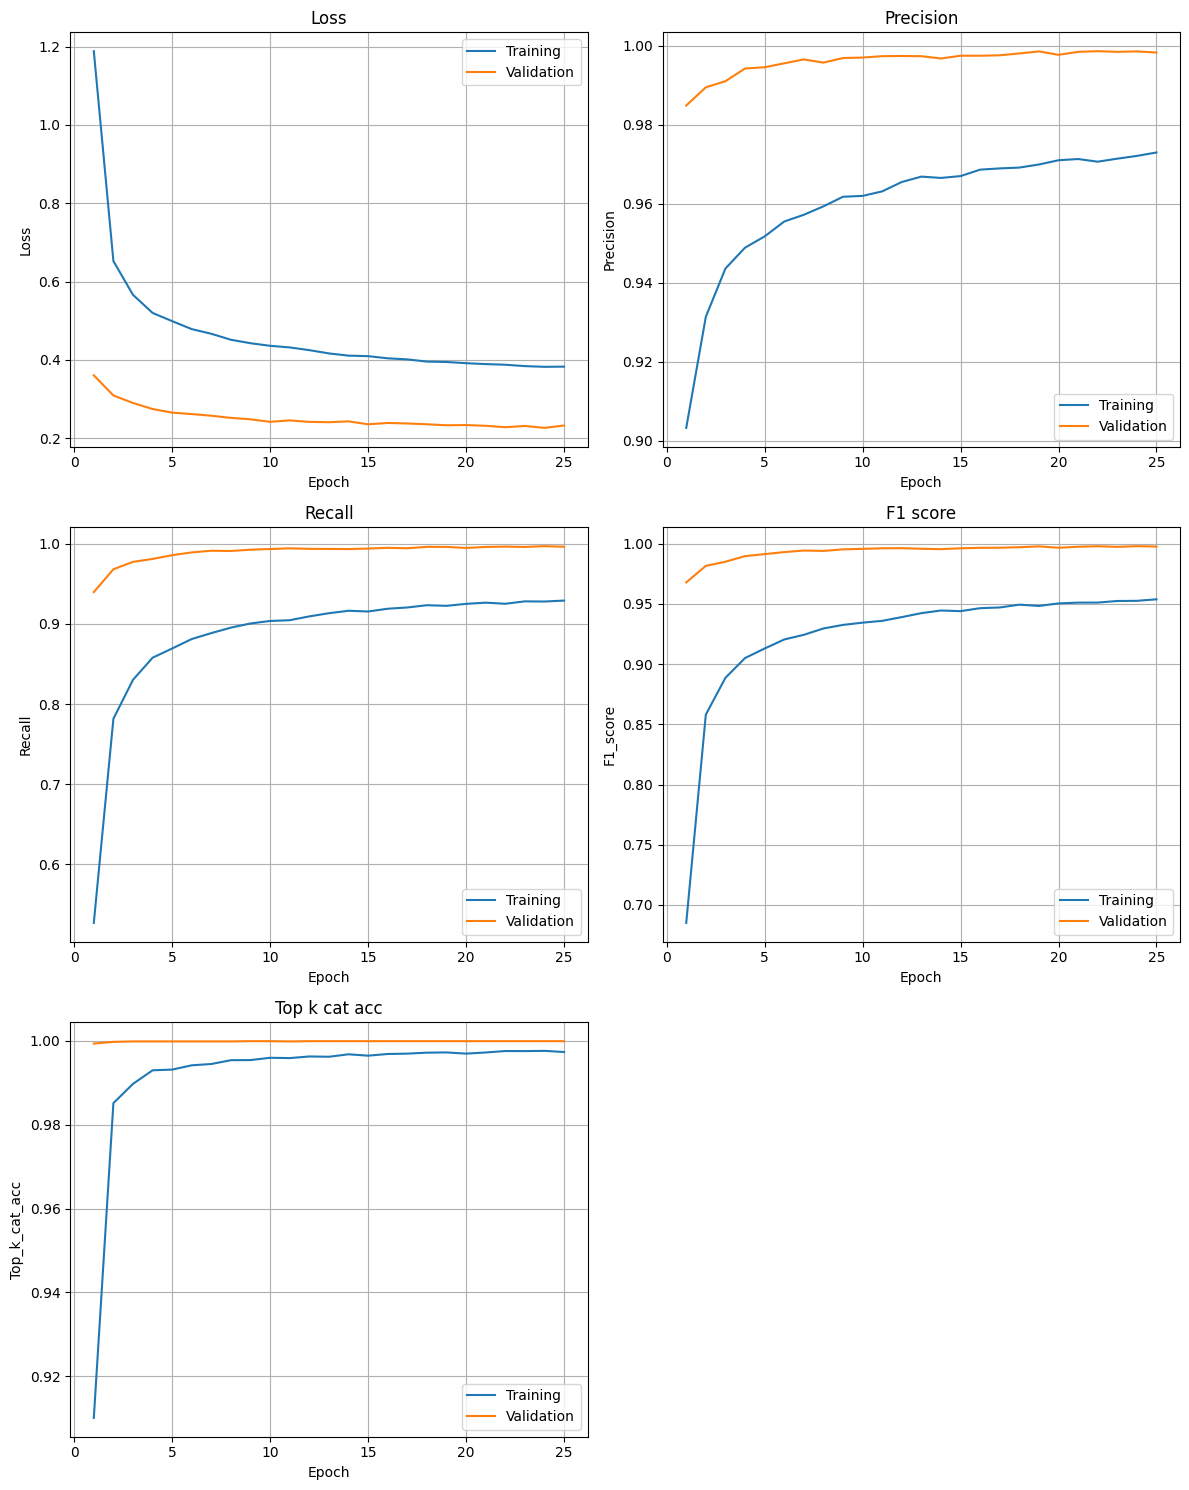

In [20]:
metrics = ['loss', 'precision', 'recall', 'f1_score', 'top_k_cat_acc']
graph_history_metrics(history_tl, metrics, 'f1_score')

In [21]:
# CNN MODEL

try:

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
except:
    print("Multi-GPU strategy failed. Running on single device.")
    strategy = tf.distribute.get_strategy() # Default strategy

with strategy.scope():
    
    cnn_model = get_cnn_model(N_CLASSES) 
    opt_cnn = keras.optimizers.Adam()
    loss_cnn = keras.losses.CategoricalCrossentropy(label_smoothing=0.02)
   
    compile_model(cnn_model, opt_cnn, loss_cnn, get_metrics()) 

    history_cnn = cnn_model.fit(
        train_ds, 
        validation_data=test_ds, 
        epochs=EPOCHS,
        callbacks=get_callbacks('CNN', 'f1_score'), 
        verbose=1
    )

Number of devices: 1
Epoch 1/25
725/725 ━━━━━━━━━━━━━━━━━━━━ 269s 365ms/step - f1_score: 0.0126 - loss: 4.0918 - precision: 0.0384 - recall: 0.0016 - top_k_cat_acc: 0.1735 - val_f1_score: 0.0021 - val_loss: 3.3678 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_k_cat_acc: 0.1602
Epoch 2/25
725/725 ━━━━━━━━━━━━━━━━━━━━ 264s 364ms/step - f1_score: 0.0070 - loss: 3.3674 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_k_cat_acc: 0.1725 - val_f1_score: 0.0021 - val_loss: 3.3679 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_k_cat_acc: 0.1603
Epoch 3/25
725/725 ━━━━━━━━━━━━━━━━━━━━ 263s 362ms/step - f1_score: 0.0068 - loss: 3.3674 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_k_cat_acc: 0.1739 - val_f1_score: 0.0021 - val_loss: 3.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_k_cat_acc: 0.1603
Epoch 4/25
725/725 ━━━━━━━━━━━━━━━━━━━━ 263s 362ms/step - f1_score: 0.0069 - loss: 3.3674 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_

>>> Best Epoch:  5


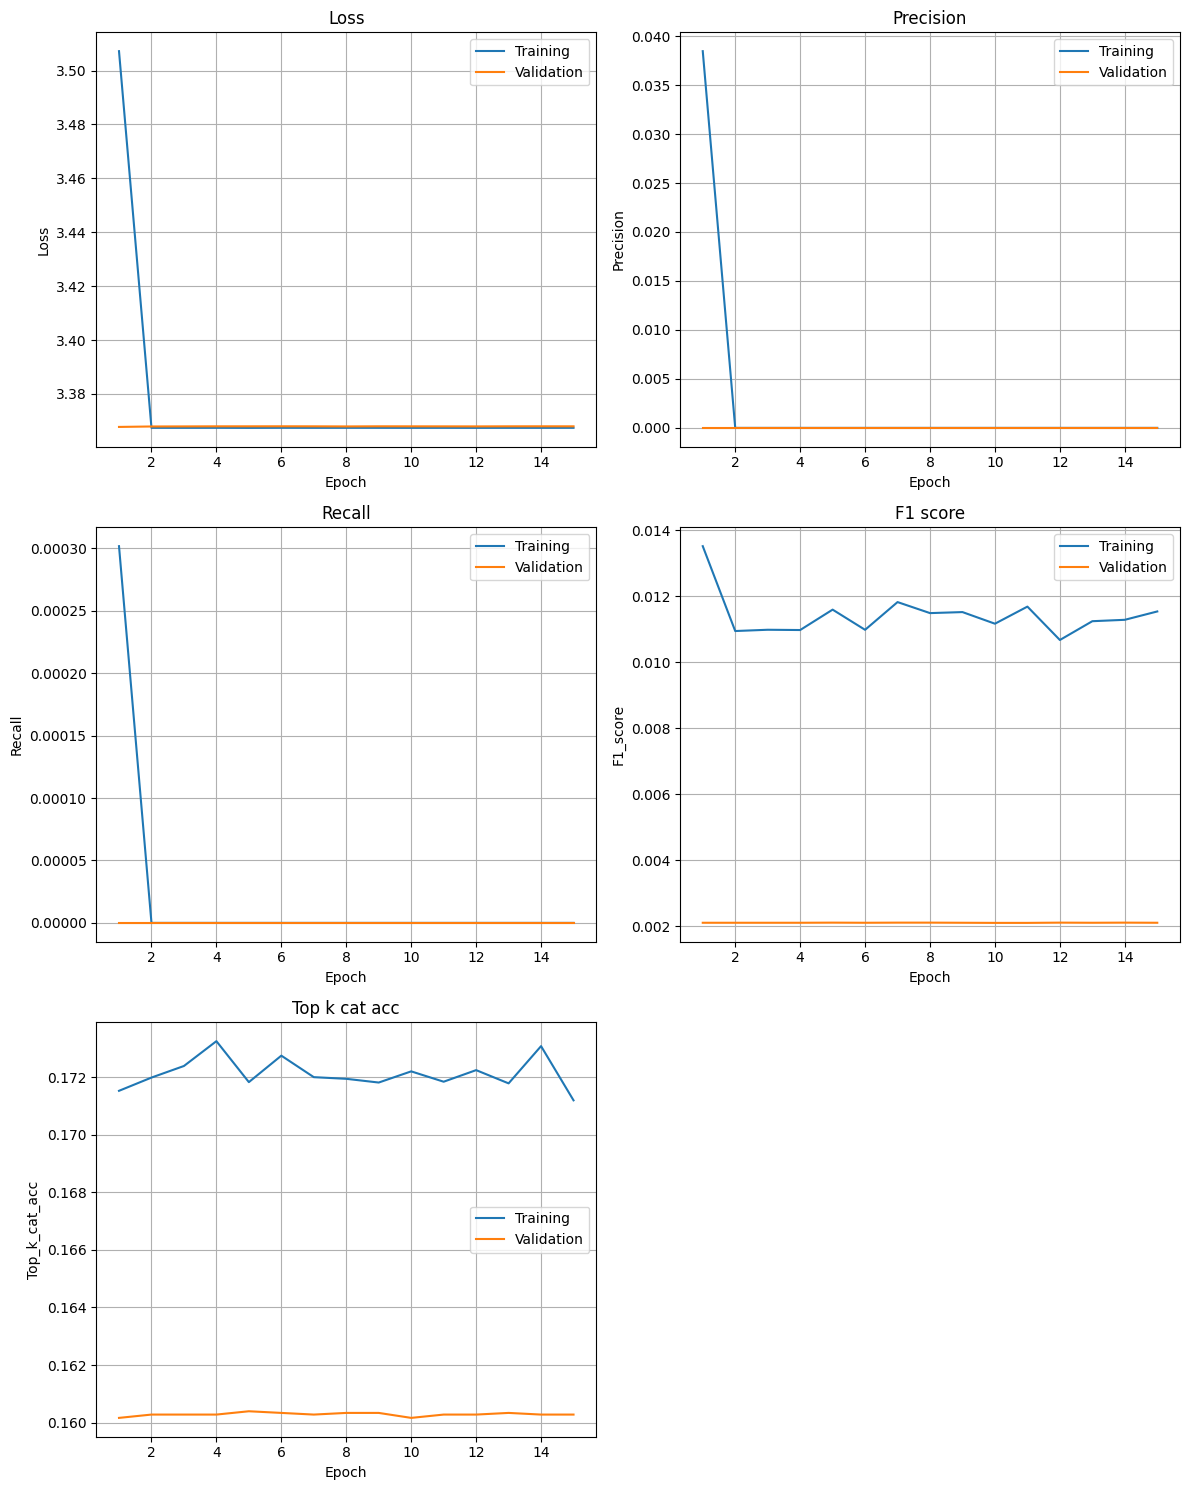

In [22]:
graph_history_metrics(history_cnn, metrics, 'f1_score')